# Lattice Programming

## What is a lattice

- Very generic math structure
- For practical purposes: just a **finite** set with a subset relation
- Paired with ``fixpoint operators``: functions that either
    - Follow the lines upwards
    - Stop
- Conditions above can be relaxed, but at the cost of complexity

## Lattice programming
- Partial solutions
- Guaranteed termination (through monotonicity)
- Very modular / elegant
- Sane recursive functions - no induction
- Theory, not implementation

## Example Visualization



In [119]:
from graphviz import Digraph
from IPython.display import Image

def new_graph(name: str):
    return Digraph(
        name=name,
        node_attr={"shape": "circle", "style": "filled"},
        graph_attr={"bgcolor": "transparent", "splines": "line", "rankdir": "BT"},
        edge_attr={"arrowsize": "0.75"},
        strict=True,
    )

def render(dot: Digraph):
    dot.render(filename=dot.name, format="png", directory="./graphs")
    return f"graphs/{dot.name}.png"


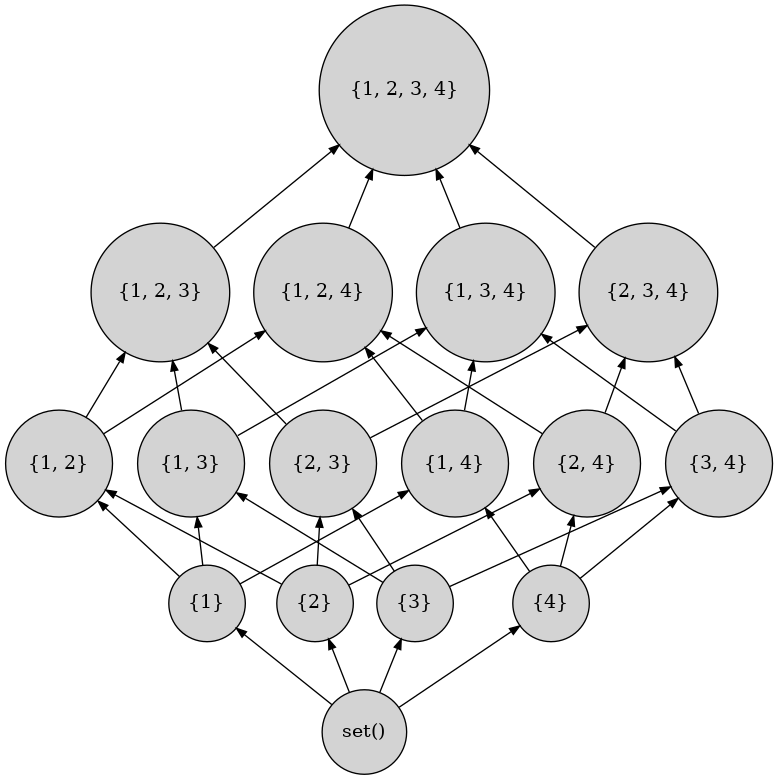

In [120]:
from more_itertools import powerset, distinct_combinations

graph = new_graph("graph1")

domain = {1, 2, 3, 4}
domain_subsets = tuple((str(i), set(subset)) for i, subset in enumerate(powerset(domain)))


for label, subset in domain_subsets:
    graph.node(name=label, label=str(subset))

for (labelA, subsetA), (labelB, subsetB) in distinct_combinations(domain_subsets, 2):
    if len(subsetB) - len(subsetA) == 1 and subsetA.issubset(subsetB):
        graph.edge(labelA, labelB)


Image(render(graph))


## Problem

- A diagnosis approach to parts of speech tagging (POS tagging)
    - Diagnostics propose a tag, then possibly refute it
- POS: noun, verb, adverb, subject
### Lattice
- Domain: pairs (word, tag) where word is a word and tag is the word's pos
- Computation: start with the TOP, apply every operator in composition until a fixpoint is reached

In [121]:
from itertools import product

words = ("the", "quick", "brown", "fox", "jumps", "over", "the", "lazy", "dog")
tags = ("DET", "NOUN(OBJ)", "NOUN(SUBJECT)", "VERB")


domain = tuple(product(words, tags))

print(domain)
print(f"There are {len(domain)} elements in the domain")
print(f"Which means there are (2^{len(domain)} = {2**len(domain)}) possible subsets")
print("Can't be visualized, but can easily be encoded with bitsets/bitflags")


(('the', 'DET'), ('the', 'NOUN(OBJ)'), ('the', 'NOUN(SUBJECT)'), ('the', 'VERB'), ('quick', 'DET'), ('quick', 'NOUN(OBJ)'), ('quick', 'NOUN(SUBJECT)'), ('quick', 'VERB'), ('brown', 'DET'), ('brown', 'NOUN(OBJ)'), ('brown', 'NOUN(SUBJECT)'), ('brown', 'VERB'), ('fox', 'DET'), ('fox', 'NOUN(OBJ)'), ('fox', 'NOUN(SUBJECT)'), ('fox', 'VERB'), ('jumps', 'DET'), ('jumps', 'NOUN(OBJ)'), ('jumps', 'NOUN(SUBJECT)'), ('jumps', 'VERB'), ('over', 'DET'), ('over', 'NOUN(OBJ)'), ('over', 'NOUN(SUBJECT)'), ('over', 'VERB'), ('the', 'DET'), ('the', 'NOUN(OBJ)'), ('the', 'NOUN(SUBJECT)'), ('the', 'VERB'), ('lazy', 'DET'), ('lazy', 'NOUN(OBJ)'), ('lazy', 'NOUN(SUBJECT)'), ('lazy', 'VERB'), ('dog', 'DET'), ('dog', 'NOUN(OBJ)'), ('dog', 'NOUN(SUBJECT)'), ('dog', 'VERB'))
There are 36 elements in the domain
Which means there are (2^36 = 68719476736) possible subsets
Can't be visualized, but can easily be encoded with bitsets/bitflags


# Linguistic Diagnosis

- Method stolen from classical linguistics ([uoa reference](https://ezpa.library.ualberta.ca/ezpAuthen.cgi?url=https://academic.oup.com/book/12008/chapter-abstract/161275349?redirectedFrom=fulltext)) ([non uoa, gated](https://academic.oup.com/book/12008/chapter/161275349?login=true))
- Rooted in generative grammar
- Simplified here
- Operate on template sentences:
- E.g. "The dog kicked the ball" -> ("Who kicked the ball?", "Dog") is true, then dog is NOUN(SUBJECT) 
- Oracle-driven
    - In classical linguistics, the linguist is the oracle
    - Oracle can be a trained NN
    - Or a corpus/database
    - ... doesn't really matter

In [122]:
# Diagnostic functions, lattice operators

LatticeElement = set[tuple[str, str]]

def adjacent_right_tags(word: str, element: LatticeElement) -> tuple[str]:
    i = words.index(word)
    if i >= len(words)-1:
        return tuple()
    word = words[i+1]
    return tuple(tag for oword, tag in element if word == oword)

def jumps_is_verb(element: LatticeElement) -> LatticeElement:
    return {
        (word, tag)
        for word, tag in element
        if word != "jumps" or tag == "VERB"
    }

#print(jumps_is_verb({("the", "DET"), ("the", "VERB"), ("jumps", "NOUN(SUBJECT)"), ("jumps", "VERB")}))

# Don't consider anything a DET if it doesn't come before a NOUN(SUBJECT), NOUN(OBJECT)
def remove_det_nonoun(element: LatticeElement) -> LatticeElement:
    return {
        (word, tag) for word, tag in element
        if tag != "DET" or {"NOUN(OBJ)", "NOUN(SUBJECT)"}.intersection(adjacent_right_tags(word, element))
    }

# Can't have two nouns next to eachother (e.g. dog cat)
def remove_noun_nodoubles(element: LatticeElement) -> LatticeElement:
    return {
        (word, tag) for word, tag in element
        if tag not in ("NOUN(OBJ)", "NOUN(SUBJECT)") or not ({"NOUN(OBJ)", "NOUN(SUBJECT)"}.issuperset(x := adjacent_right_tags(word, element)) and len(x) != 0)
    }


from itertools import chain
first_three = words[:3]
first_three_nouns_dets = tuple(chain.from_iterable(((word, "DET"), (word, "NOUN(OBJ)")) for word in first_three))
print(first_three_nouns_dets)
print(remove_noun_nodoubles({*first_three_nouns_dets, ("fox", "NOUN(SUBJECT)")}))

# A noun always comes right before a verb
def noun_immediately_precedes_verb(element: LatticeElement) -> LatticeElement:
    return {
        (word, tag) for word, tag in element
        if tag in ("NOUN(OBJ)", "NOUN(SUBJECT)") or ("VERB",) != adjacent_right_tags(word, element)
    }

#print(noun_immediately_precedes_verb({("fox", "DET"), ("fox", "NOUN(OBJ)"), ("jumps", "VERB")}))



(('the', 'DET'), ('the', 'NOUN(OBJ)'), ('quick', 'DET'), ('quick', 'NOUN(OBJ)'), ('brown', 'DET'), ('brown', 'NOUN(OBJ)'))
{('quick', 'NOUN(OBJ)'), ('fox', 'NOUN(SUBJECT)'), ('quick', 'DET'), ('the', 'NOUN(OBJ)'), ('brown', 'DET'), ('the', 'DET')}


In [123]:
# Every word needs at least one part of speech
def consistent(element: LatticeElement) -> bool:
    return len(set(word for word, _ in element)) == len(set(words))

print("The lattice top element, every word has every tag:")
assert consistent(domain)
assert not consistent({("jumps", "VERB")})

# Every word has exactly one tag
def model(element: LatticeElement) -> bool:
    return consistent(element) and len(element) == len(set(words))

assert not model(domain)
assert model({(word, "DET") for word in words})

operators = [jumps_is_verb, remove_det_nonoun, remove_noun_nodoubles, noun_immediately_precedes_verb]

def with_info(operator, x: LatticeElement) -> LatticeElement:
    print(f"Calling with {operator.__name__}")
    result = operator(x)
    print(f"{operator.__name__} removed {len(x) - len(result)} elements")
    print(x.difference(result))
    return result

def compose(f1, f2):
    return lambda x: f1(f2(x))

from functools import reduce, partial
from pprint import pprint
all_operator = reduce(compose, map(partial(partial, with_info), operators))

def fixpoint(op, start):
    print(f"Start size = {len(start)}")
    i = 0
    while (succ := op(start)) != start:
        print(f"Iteration {i} size = {len(succ)}")
        pprint(succ)
        start = succ
        i += 1
    print("Reached Fixedpoint")
    return start


fixpoint(all_operator, set(domain))


The lattice top element, every word has every tag:
Start size = 32
Calling with noun_immediately_precedes_verb
noun_immediately_precedes_verb removed 0 elements
set()
Calling with remove_noun_nodoubles
remove_noun_nodoubles removed 0 elements
set()
Calling with remove_det_nonoun
remove_det_nonoun removed 1 elements
{('dog', 'DET')}
Calling with jumps_is_verb
jumps_is_verb removed 3 elements
{('jumps', 'DET'), ('jumps', 'NOUN(OBJ)'), ('jumps', 'NOUN(SUBJECT)')}
Iteration 0 size = 28
{('brown', 'DET'),
 ('brown', 'NOUN(OBJ)'),
 ('brown', 'NOUN(SUBJECT)'),
 ('brown', 'VERB'),
 ('dog', 'NOUN(OBJ)'),
 ('dog', 'NOUN(SUBJECT)'),
 ('dog', 'VERB'),
 ('fox', 'DET'),
 ('fox', 'NOUN(OBJ)'),
 ('fox', 'NOUN(SUBJECT)'),
 ('fox', 'VERB'),
 ('jumps', 'VERB'),
 ('lazy', 'DET'),
 ('lazy', 'NOUN(OBJ)'),
 ('lazy', 'NOUN(SUBJECT)'),
 ('lazy', 'VERB'),
 ('over', 'DET'),
 ('over', 'NOUN(OBJ)'),
 ('over', 'NOUN(SUBJECT)'),
 ('over', 'VERB'),
 ('quick', 'DET'),
 ('quick', 'NOUN(OBJ)'),
 ('quick', 'NOUN(SUBJECT)

{('brown', 'DET'),
 ('brown', 'VERB'),
 ('dog', 'NOUN(OBJ)'),
 ('dog', 'NOUN(SUBJECT)'),
 ('dog', 'VERB'),
 ('fox', 'NOUN(OBJ)'),
 ('fox', 'NOUN(SUBJECT)'),
 ('jumps', 'VERB'),
 ('lazy', 'DET'),
 ('lazy', 'NOUN(OBJ)'),
 ('lazy', 'NOUN(SUBJECT)'),
 ('lazy', 'VERB'),
 ('over', 'DET'),
 ('over', 'NOUN(OBJ)'),
 ('over', 'NOUN(SUBJECT)'),
 ('over', 'VERB'),
 ('quick', 'NOUN(OBJ)'),
 ('quick', 'NOUN(SUBJECT)'),
 ('quick', 'VERB'),
 ('the', 'DET'),
 ('the', 'NOUN(OBJ)'),
 ('the', 'NOUN(SUBJECT)'),
 ('the', 'VERB')}

# Exercises
1. Build a sentence for which the above operators produce inconsistent results
1. Construct more operators that complete the sentence
1. Rebuild the code so that it starts with the empty set and adds the POS it refutes

# A fuzzier approach

- Binary deciding expects a lot from diagnostics
- Graded approach would be beter
- Modify to use triple (word: str, tag: str, confidence: float)
